In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import os
import cv2

from keras.models import Sequential
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from pandas_datareader import data#Download data from the web via this package
%matplotlib inline 

In [2]:
GSPC = pd.read_csv('GSPC_index_close.csv')
del GSPC['Date']
GSPC=GSPC.T
GSPC_noisy = pd.DataFrame(np.repeat(GSPC.values,50,axis=0))
GSPC_noisy=GSPC_noisy.iloc[:, 52:]


In [3]:
GSPC_noisy

,52,53,54,55,56,57,58,59,60,61,...,492,493,494,495,496,497,498,499,500,501
0,2373.469971,2344.02002,2348.449951,2345.959961,2343.97998,2341.590088,2358.570068,2361.129883,2368.060059,2362.719971,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098
1,2373.469971,2344.02002,2348.449951,2345.959961,2343.97998,2341.590088,2358.570068,2361.129883,2368.060059,2362.719971,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098
2,2373.469971,2344.02002,2348.449951,2345.959961,2343.97998,2341.590088,2358.570068,2361.129883,2368.060059,2362.719971,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098
3,2373.469971,2344.02002,2348.449951,2345.959961,2343.97998,2341.590088,2358.570068,2361.129883,2368.060059,2362.719971,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098
4,2373.469971,2344.02002,2348.449951,2345.959961,2343.97998,2341.590088,2358.570068,2361.129883,2368.060059,2362.719971,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098
5,2373.469971,2344.02002,2348.449951,2345.959961,2343.97998,2341.590088,2358.570068,2361.129883,2368.060059,2362.719971,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098
6,2373.469971,2344.02002,2348.449951,2345.959961,2343.97998,2341.590088,2358.570068,2361.129883,2368.060059,2362.719971,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098
7,2373.469971,2344.02002,2348.449951,2345.959961,2343.97998,2341.590088,2358.570068,2361.129883,2368.060059,2362.719971,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098
8,2373.469971,2344.02002,2348.449951,2345.959961,2343.97998,2341.590088,2358.570068,2361.129883,2368.060059,2362.719971,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098
9,2373.469971,2344.02002,2348.449951,2345.959961,2343.97998,2341.590088,2358.570068,2361.129883,2368.060059,2362.719971,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098


In [4]:
close=np.array(GSPC)[0]
GSPC_pure=pd.DataFrame()
for i in range(2,52):#SMA
    #print(i)
    n=np.ones(i)
    weights=n/i
    empty=np.ones(i-1)
    sma=np.convolve(weights,close)[i-1:-i+1]
    sma_full=np.hstack((empty,sma))
    GSPC_pure=pd.concat([GSPC_pure, pd.DataFrame(sma_full).T],ignore_index=True)
GSPC_pure=GSPC_pure.iloc[:, 52:]

In [5]:
GSPC_pure

,52,53,54,55,56,57,58,59,60,61,...,492,493,494,495,496,497,498,499,500,501
0,2375.859985,2358.744995,2346.234985,2347.204956,2344.969971,2342.785034,2350.080078,2359.849976,2364.594971,2365.390015,...,2572.944946,2546.049927,2526.559937,2487.189941,2442.020020,2383.860107,2409.400024,2478.265015,2487.285034,2496.295044
1,2377.699951,2365.246663,2355.313314,2346.143311,2346.129964,2343.843343,2348.046712,2353.763346,2362.586670,2363.969971,...,2598.809977,2564.016602,2533.019938,2506.846598,2463.666667,2411.713379,2411.806722,2435.876709,2480.756673,2493.806722
2,2379.589966,2369.279968,2361.047485,2352.974976,2345.602478,2344.994995,2347.525024,2351.317505,2357.337524,2362.619995,...,2611.875000,2585.647461,2549.752441,2516.619934,2484.289978,2435.525024,2425.710022,2431.062561,2448.342529,2487.280029
3,2376.761963,2372.475977,2365.113965,2358.029980,2351.175977,2344.800000,2347.710010,2350.245996,2354.666016,2358.414014,...,2616.856006,2598.731982,2569.909961,2533.285938,2496.619971,2457.652002,2441.960010,2438.334033,2441.998047,2460.044043
4,2376.213298,2371.304972,2368.471639,2361.921631,2355.688314,2349.578328,2347.095011,2349.946655,2353.215007,2356.008341,...,2620.333333,2605.073324,2583.436646,2552.828288,2513.841634,2472.366659,2459.326660,2449.771688,2446.235026,2452.806722
5,2375.697126,2371.614258,2368.039969,2365.255685,2359.358538,2353.674282,2350.862863,2349.099993,2352.534284,2354.572859,...,2622.154297,2609.737130,2591.057129,2566.862828,2533.369978,2490.592843,2471.699986,2463.541434,2454.910017,2454.894322
6,2374.343750,2371.737488,2368.718719,2365.279968,2362.596222,2357.137482,2354.286255,2352.146240,2351.470001,2353.807495,...,2631.378754,2612.654999,2596.889984,2575.602478,2548.082489,2510.586243,2487.731232,2473.841248,2466.316254,2461.402527
7,2373.081109,2370.974447,2369.149984,2366.189969,2362.913303,2360.262207,2357.296658,2355.046658,2353.914442,2352.719998,...,2639.010010,2621.909993,2600.911106,2582.504422,2557.937771,2526.195557,2505.821099,2487.853326,2475.163330,2470.820014
8,2372.611987,2370.175000,2368.721997,2366.830981,2363.968970,2360.780981,2360.092993,2357.679980,2356.347998,2354.794995,...,2654.146021,2629.725000,2610.414990,2587.561987,2565.915991,2537.254004,2520.345996,2504.121997,2487.641992,2478.332007
9,2372.857267,2370.012718,2368.199996,2366.652721,2364.753618,2361.934526,2360.579989,2360.187256,2358.623624,2356.927268,...,2663.784557,2644.329102,2618.564542,2597.415439,2572.021817,2546.387274,2530.930908,2517.480913,2502.450906,2489.388184


In [32]:
train=np.array(GSPC_noisy)
train=np.reshape(train, (50, 450, 1))

In [33]:
train_cleaned=np.array(GSPC_pure)
train_cleaned=np.reshape(train_cleaned, (50, 450, 1))

In [34]:
# convert list to numpy array
X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

In [35]:
def set_model_encoding():
    model = Sequential()
    #encoding
    model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same',input_shape=(450, 1)))
    model.add(Conv1D(64, kernel_size=3,activation='relu',padding='same'))
    model.add(BatchNormalization())
    #Use the normalization preprocessing of the data as mentioned before, so that the input x does not vary too much
    model.add(MaxPooling1D(2, padding='same'))
    model.add(Dropout(0.5))
    #decoding
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(Conv1D(32, kernel_size=3,activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(UpSampling1D(2))
    
    model.add(Conv1D(1,kernel_size=3,activation='sigmoid', padding='same'))
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])
    
    return model
    

In [36]:
modelen = set_model_encoding()
modelen.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 450, 32)           128       
                                                                 
 conv1d_11 (Conv1D)          (None, 450, 64)           6208      
                                                                 
 batch_normalization_4 (Batc  (None, 450, 64)          256       
 hNormalization)                                                 
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 225, 64)          0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 225, 64)           0         
                                                                 
 conv1d_12 (Conv1D)          (None, 225, 64)          

In [40]:
callback = EarlyStopping(monitor='loss', patience=30)
history = modelen.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=600, batch_size=24, verbose=0, callbacks=[callback])

In [41]:
modelen.save_weights('model_weights.h5', overwrite=True)  

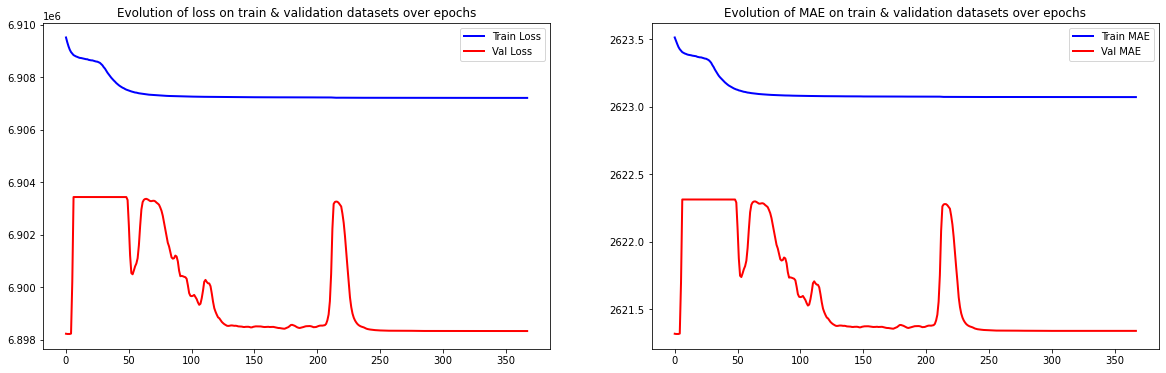

In [42]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

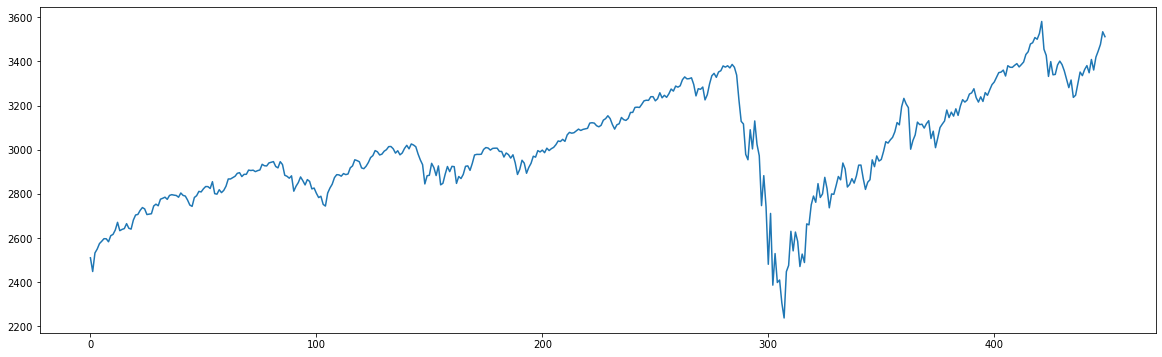

In [43]:
GSPC_test = pd.read_csv('GSPC_index_close_test_201922.csv')
del GSPC_test['Date']
#GSPC_test=GSPC_test.T
GSPC_test=GSPC_test[0:450]
plt.figure(figsize=(20,6))
plt.plot(GSPC_test)


In [44]:
Y_test = modelen.predict(GSPC_test.T, batch_size=16)

1/1 [==============================] - 0s 110ms/step


In [49]:
Y_test=Y_test.reshape((450,1))

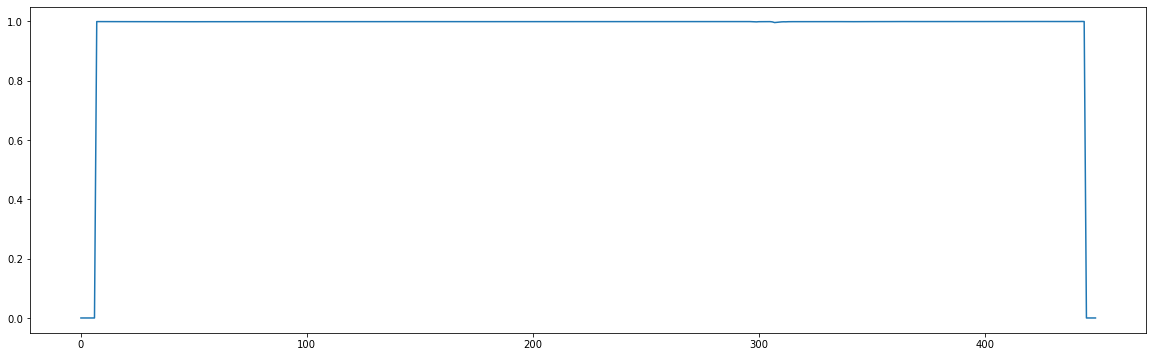

In [46]:
plt.figure(figsize=(20,6))
plt.plot(Y_test)

In [47]:
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler()
test_mm = mm.fit_transform(GSPC_test)

In [50]:
Y_test_inv=mm.inverse_transform(Y_test)